# Evaluate PointNet Classification on ModelNet40
Let's first evaluate on a single example.

In [1]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import seaborn as sns
from Models.pointnet import PointNetClassification
from custom_datasets import ModelNetDataLoader


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Testing on {device}")

Testing on cuda


In [2]:
model_path = "exps/train2/best_model.pth"
pretrained = torch.load(model_path, map_location=torch.device(device))
print("Pretrained for", pretrained["epoch"])

model = PointNetClassification(k=40, normal_channel=False)
model.load_state_dict(pretrained["model_state_dict"])
model.to(device)

print()

Pretrained for 95



In [3]:
# Load test data
data_path = "data/modelnet40_normal_resampled/"
test_dataset   = ModelNetDataLoader(root=data_path, 
                                     num_point=1024, 
                                     use_uniform_sample=False,
                                     use_normals=False,
                                     num_category=40,
                                     split='test', 
                                     process_data=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4)

In [4]:
# Visualize te Data
# Histograph of classes
print(len(test_dataset))

2468


ModelNet40 Test Dataset: 2468
Instance shape: (1024, 3)
Label shape: ()
<class 'numpy.ndarray'>
<class 'numpy.int32'>
int32


Sample class: piano


Text(0.5, 0.92, 'Sample Point Cloud of a piano object')

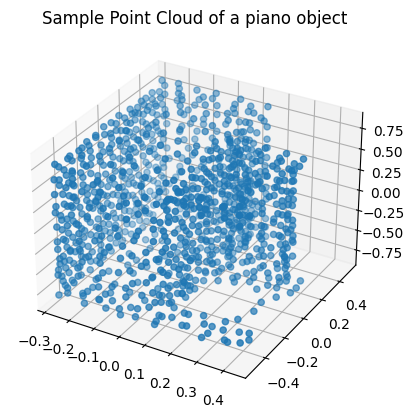

In [5]:
# Visualize one random sample
print("ModelNet40 Test Dataset: %d" % len(test_dataset))

instance, label = test_dataset[0]
print("Instance shape:", instance.shape)
print("Label shape:", label.shape)

print(type(instance))
print(type(label))
print(label.dtype)

# Take one sample from the dataloader
batch_sample = next(iter(test_dataloader))
batch_sample_point_set = batch_sample[0]
batch_sample_label = batch_sample[1]

sample_point_set = batch_sample_point_set[0]
sample_label = batch_sample_label[0]
sample = sample_point_set.numpy()


idx_classes = test_dataset.idx_classes
cls = idx_classes[sample_label.item()]
print("Sample class: %s" % idx_classes[sample_label.item()])

X, Y, Z = sample[:, 0], sample[:, 1], sample[:, 2]


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X, Y, Z)

plt.title(f"Sample Point Cloud of a {cls} object")

In [7]:
# Predict the class of the sample
model.eval()
with torch.inference_mode():
    points = sample_point_set.unsqueeze(0)
    points = points.transpose(2, 1)
    print(points.shape)
    points = points.to(device)
    pred, trans_feat = model(points)
    pred_class = pred.data.max(1)[1].item()
    
print(f"Predicted class: {idx_classes[pred_class]}")


torch.Size([1, 3, 1024])
Predicted class: piano


Next let's evaluate the overall classification, per class accuracy, and show confusion matrix. Below are some explanations of evaluation code.

Explanation of `vote_pool`
> `vote_pool` 是一个用于存储每个样本的类别预测得分的张量。它的形状是 `(batch_size, num_classes)`，其中 `batch_size` 是批次中的样本数量，`num_classes` 是类别的数量。在每次投票循环中，模型会对输入的点云进行预测，得到一个形状为 `(batch_size, num_classes)` 的预测得分张量，然后将这个张量加到 `vote_pool` 中。这样，`vote_pool` 中的每个元素都是同一个样本在多次预测中得到的类别得分的累加。在所有投票循环结束后，`vote_pool` 中的每个元素会被除以投票次数，得到每个样本每个类别的平均预测得分。然后，通过取每行的最大值的索引，可以得到模型对每个样本的最终预测类别。

Essentially, we perform prediction on the same batch `vote_num` times and save each prediction to `vote_pool`, then divides by `vote_num` to get the average.

Explanation of `class_acc`
> `class_acc` 是一个用于记录每个类别预测准确率的数组。它的形状是 `(num_classes, 3)`，其中 `num_classes` 是类别的数量。
> - `class_acc[:, 0]` 存储的是每个类别的预测正确的样本数量。
> - `class_acc[:, 1]` 存储的是每个类别的样本总数。
> - `class_acc[:, 2]` 存储的是每个类别的预测准确率，即 `class_acc[:, 0] / class_acc[:, 1]`。

> 在每个批次的循环中，代码会更新 `class_acc` 的前两列。然后在循环结束后，计算每个类别的预测准确率，并将结果存储在 `class_acc[:, 2]` 中。最后，`class_acc` 被赋值为所有类别预测准确率的平均值，这是模型在所有类别上的平均预测准确率。


In [8]:
# Perform evaluation on entire test set, find total accuracy, class accuracy, confusion matrix
# total_acc -> number of objects that are correct identified / total number of objects
# class_acc -> accuracy per class

model.eval()
num_classes = 40
vote_num = 1
class_acc = np.zeros((num_classes, 3)) 
loader = test_dataloader
total_acc, class_acc_ = 0.0, 0.0
confusion_matrix = np.zeros((num_classes, num_classes))

with torch.inference_mode():
    for batch_idx, (points, target) in tqdm(enumerate(loader), total=len(loader)):
        if device == "cuda":
            points, target = points.to(device), target.to(device)
            
        points = points.transpose(2, 1) # (batch, num_point, dim), (32, 1024, 3) -> (32, 3, 1024)
        vote_pool = torch.zeros(target.size()[0], num_classes).to(device) # (batch_size, num_classes)
    
        for _ in range(vote_num):
            pred, _ = model(points)
            vote_pool += pred   
        pred = vote_pool / vote_num
        pred_choice = pred.data.max(1)[1]
        
        # Confusion Matrix
        for i in range(len(target)):
            confusion_matrix[target[i]][pred_choice[i]] += 1

        # Accuracy per class
        for cat in np.unique(target.cpu()):
            classacc = pred_choice[target == cat].eq(target[target == cat].long().data).cpu().sum()
            class_acc[cat, 0] += classacc.item() / float(points[target == cat].size()[0])
            class_acc[cat, 1] += 1

        correct = pred_choice.eq(target.long().data).cpu().sum()
        total_acc += correct.item() / float(points.size()[0]) # number of correct / number of points in batch
        
    class_acc[:, 2] = class_acc[:, 0] / class_acc[:, 1]
    class_acc = np.mean(class_acc[:, 2])
    
    total_acc = total_acc / len(loader)
    # class_acc = class_acc / len(loader)

    print(f"Total accuracy {total_acc}")
    print(f"Class accuracy {class_acc}")

  0%|          | 0/78 [00:00<?, ?it/s]


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

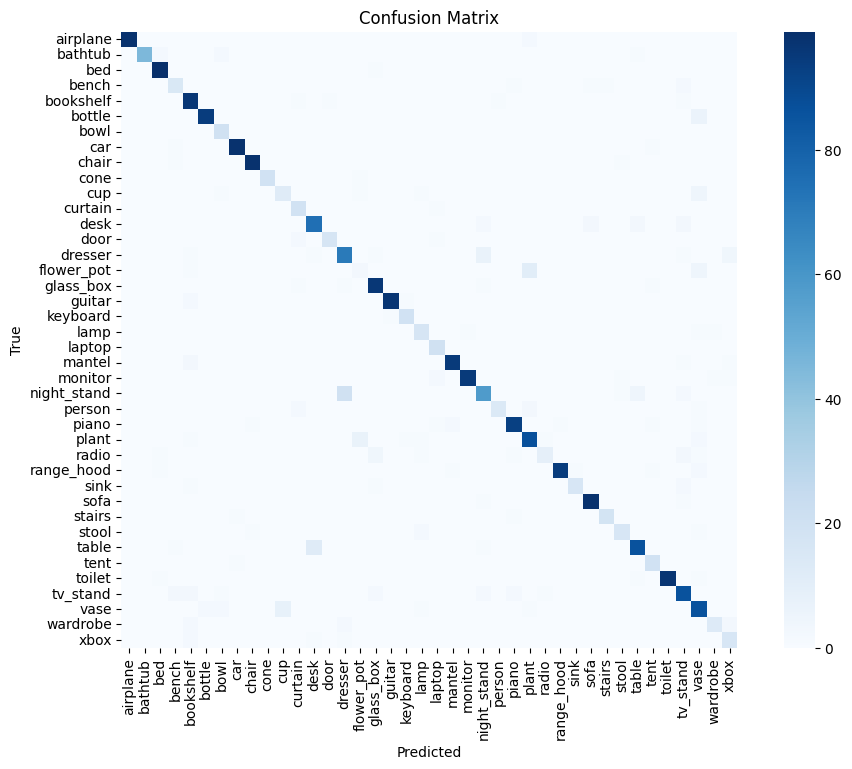

In [ ]:
# Create a heatmap
plt.figure(figsize=(12, 8))
class_names = [test_dataset.idx_classes[i] for i in range(num_classes)]
sns.heatmap(confusion_matrix, cmap='Blues', square=True,
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()